# Setup 
(mostly refactored and copy pasted from https://colab.research.google.com/drive/1u8larhpxy8w4mMsJiSBddNOzFGj7_RTn?usp=sharing)

## Dependencies

In [ ]:
!py -V

In [ ]:
!pip install transformer_lens
!pip install gradio
!pip install seaborn

In [ ]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")
import features_utils
import graph_code
from transformer_lens import HookedTransformer, utils
import torch
import seaborn as sns 
import numpy as np
import gradio as gr
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import plotly.express as px
import pandas as pd
import pickle
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from torch import Tensor
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dill as pickle
from autoencoder import AutoEncoder, DTYPES

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Visualise Feature Utils

In [3]:
from html import escape
import colorsys

from IPython.display import display

SPACE = "·"
NEWLINE="↩"
TAB = "→"

def create_html(strings, values, max_value=None, saturation=0.5, allow_different_length=False, return_string=False):
    # escape strings to deal with tabs, newlines, etc.
    escaped_strings = [escape(s, quote=True) for s in strings]
    processed_strings = [
        s.replace("\n", f"{NEWLINE}<br/>").replace("\t", f"{TAB}&emsp;").replace(" ", "&nbsp;")
        for s in escaped_strings
    ]

    if isinstance(values, torch.Tensor) and len(values.shape)>1:
        values = values.flatten().tolist()

    if not allow_different_length:
        assert len(processed_strings) == len(values)

    # scale values
    if max_value is None:
        max_value = max(max(values), -min(values))+1e-3
    scaled_values = [v / max_value * saturation for v in values]

    # create html
    html = ""
    for i, s in enumerate(processed_strings):
        if i<len(scaled_values):
            v = scaled_values[i]
        else:
            v = 0
        if v < 0:
            hue = 0  # hue for red in HSV
        else:
            hue = 0.66  # hue for blue in HSV
        rgb_color = colorsys.hsv_to_rgb(
            hue, v, 1
        )  # hsv color with hue 0.66 (blue), saturation as v, value 1
        hex_color = "#%02x%02x%02x" % (
            int(rgb_color[0] * 255),
            int(rgb_color[1] * 255),
            int(rgb_color[2] * 255),
        )
        html += f'<span style="background-color: {hex_color}; border: 1px solid lightgray; font-size: 16px; border-radius: 3px;">{s}</span>'
    if return_string:
        return html
    else:
        display(HTML(html))

def basic_feature_vis(text, feature_index, max_val=0):
    feature_in = encoder.W_enc[:, feature_index]
    feature_bias = encoder.b_enc[feature_index]
    _, cache = model.run_with_cache(text, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
    mlp_acts = cache[utils.get_act_name("post", 0)][0]
    feature_acts = F.relu((mlp_acts - encoder.b_dec) @ feature_in + feature_bias)
    if max_val==0:
        max_val = max(1e-7, feature_acts.max().item())
        # print(max_val)
    # if min_val==0:
    #     min_val = min(-1e-7, feature_acts.min().item())
    return basic_token_vis_make_str(text, feature_acts, max_val)
def basic_token_vis_make_str(strings, values, max_val=None):
    if not isinstance(strings, list):
        strings = model.to_str_tokens(strings)
    values = utils.to_numpy(values)
    if max_val is None:
        max_val = values.max()
    # if min_val is None:
    #     min_val = values.min()
    header_string = f"<h4>Max Range <b>{values.max():.4f}</b> Min Range: <b>{values.min():.4f}</b></h4>"
    header_string += f"<h4>Set Max Range <b>{max_val:.4f}</b></h4>"
    # values[values>0] = values[values>0]/ma|x_val
    # values[values<0] = values[values<0]/abs(min_val)
    body_string = create_html(strings, values, max_value=max_val, return_string=True)
    return header_string + body_string
# display(HTML(basic_token_vis_make_str(tokens[0, :10], mlp_acts[0, :10, 7], 0.1)))
# # %%
# The `with gr.Blocks() as demo:` syntax just creates a variable called demo containing all these components
import gradio as gr
try:
    demos[0].close()
except:
    pass
demos = [None]
def make_feature_vis_gradio(feature_id, starting_text=None, batch=None, pos=None):
    if starting_text is None:
        starting_text = model.to_string(all_tokens[batch, 1:pos+1])
    try:
        demos[0].close()
    except:
        pass
    with gr.Blocks() as demo:
        gr.HTML(value=f"Hacky Interactive Neuroscope for gelu-1l")
        # The input elements
        with gr.Row():
            with gr.Column():
                text = gr.Textbox(label="Text", value=starting_text)
                # Precision=0 makes it an int, otherwise it's a float
                # Value sets the initial default value
                feature_index = gr.Number(
                    label="Feature Index", value=feature_id, precision=0
                )
                # # If empty, these two map to None
                max_val = gr.Number(label="Max Value", value=None)
                # min_val = gr.Number(label="Min Value", value=None)
                inputs = [text, feature_index, max_val]
        with gr.Row():
            with gr.Column():
                # The output element
                out = gr.HTML(label="Neuron Acts", value=basic_feature_vis(starting_text, feature_id))
        for inp in inputs:
            inp.change(basic_feature_vis, inputs, out)
    demo.launch(share=True)
    demos[0] = demo

## Defining model and autoencoder config

In [4]:
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 128,
    "d_mlp": 2048,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

## Loading the Model

In [ ]:
model = HookedTransformer.from_pretrained("gelu-1l").to(DTYPES[cfg["enc_dtype"]])
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

## Loading Data

In [6]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

# Analysis

## Loading the Autoencoder and Checking reconstruction loss

There are two runs on separate random seeds, along with a bunch of intermediate checkpoints

In [ ]:
encoder_1 = AutoEncoder.load_from_hf("run1")
encoder_2 = AutoEncoder.load_from_hf("run2")

We run the model and replace the MLP activations with those reconstructed from the autoencoder, and get 91% loss recovered

In [11]:
encoder_1.get_recons_loss(model=model,
                          all_tokens=all_tokens,
                          num_batches=5, 
                          model_batch_size=cfg["model_batch_size"])

loss: 3.2424, recons_loss: 3.7315, zero_abl_loss: 8.7769
Reconstruction Score: 91.16%


(0.9116266901610738, 3.2423763275146484, 3.731480360031128, 8.776898384094238)

In [12]:
encoder_2.get_recons_loss(model=model,
                          all_tokens=all_tokens,
                          num_batches=5, 
                          model_batch_size=cfg["model_batch_size"])

loss: 3.2925, recons_loss: 3.7844, zero_abl_loss: 8.8510
Reconstruction Score: 91.15%


(0.911495984799194, 3.292466402053833, 3.7844157218933105, 8.850963592529297)

## Feature statistics

In [127]:
freqs_1 = encoder_1.get_freqs(model=model,
                              all_tokens=all_tokens,
                              batch_size=cfg["model_batch_size"],
                              num_batches = 50)

100%|██████████| 50/50 [07:43<00:00,  9.28s/it]


Num dead tensor(6.1035e-05)


In [128]:
freqs_2 = encoder_2.get_freqs(model=model,
                              all_tokens=all_tokens,
                              batch_size=cfg["model_batch_size"],
                              num_batches = 50)

100%|██████████| 50/50 [07:58<00:00,  9.57s/it]

Num dead tensor(6.1035e-05)


## Manual feature exploration

In [15]:
prompts = {}
prompt_tokens = {}
prompts['bio'] = ["This drug has unique characteristics, and nowadays it does not have analogues. It contains Isotretinoin, a structural analogue of vitamin A. As it has analogical structure to vitamin A, the therapeutic characteristics are similar.",
                "Reconstructive surgery is performed on abnormal structures of the body caused by congenital defects, developmental abnormalities, trauma, infection, tumors or disease. Generally, reconstruction is performed to improve or restore function, but it is also performed to restore form that will approximate a normal appearance. Dr. Gonzalez"]

prompts['gender_bias'] = ["Nurses handle the patients on a more intimate level than doctors, and female nurses outnumber male nurses roughly 10:1 in the US.",
                          "Nursing is a field dominated by women. And there are very large salary gaps as doctors have much higher wages than nurses.",
                          "Culture is designed around that where guys play sports, girls play with their dollhouses. Guys are tough, girls cry."]
for prompt_categ in prompts:
    prompt_tokens[prompt_categ] = model.to_tokens(prompts[prompt_categ])

### Which features activate for bio or gender related content respecively?

In [17]:
hidd_dim = cfg["d_mlp"] * cfg["dict_mult"]
prompt_acts = {}
prompt_mean_acts = {}
for prompt_categ in prompts:
    prompt_acts[prompt_categ] = torch.empty(prompt_tokens[prompt_categ].shape[0], prompt_tokens[prompt_categ].shape[1], hidd_dim)
    for i, tokens_i in enumerate(prompt_tokens[prompt_categ]):
        tokens_acts_i = encoder_1.get_ae_feature_acts(tokens=tokens_i.unsqueeze(0), model=model)
        #print(f'text={model.to_string(tokens_i)}')
        assert tokens_acts_i.shape[0] == 1, f'{tokens_acts_i.shape}'
        prompt_acts[prompt_categ][i] = tokens_acts_i[0]
    prompt_mean_acts[prompt_categ] = prompt_acts[prompt_categ].mean(axis=1) # mean across tokens

After some manual inspection and trial and error on SAE1's features:

Gender features: 10391, 12711
Biology features: 5156

## Creating a feature graph based on "co-activations"

In [ ]:
features_graph_1 = graph_code.FeatureGraph(n_hidden_ae=cfg["d_mlp"] * cfg["dict_mult"])
features_graph_1.create_edges(all_tokens=all_tokens, batch_size=128, model=model,
                            autoencoder=encoder_1, k=4, num_batches=50, log_cnt=1)
features_graph_1.save('features_ae1_graph_50b.pkl')

In [ ]:
features_graph_2 = graph_code.FeatureGraph(n_hidden_ae=cfg["d_mlp"] * cfg["dict_mult"])
features_graph_2.create_edges(all_tokens=all_tokens, batch_size=128, model=model,
                            autoencoder=encoder_2, num_batches=50, k=4, log_cnt=1)
features_graph_2.save('features_ae2_graph_50b.pkl')

### Load the feature graph

In [16]:
features_graph_1 = graph_code.FeatureGraph.load('features_ae1_graph_50b.pkl')
features_graph_2 = graph_code.FeatureGraph.load('features_ae2_graph_50b.pkl')

FeatureGraph object loaded from features_grah_51b.pkl
FeatureGraph object loaded from features_graph2_51b.pkl


### Graph statistics

In [27]:
G1 = graph_code.create_networkx_graph(features_graph_1.edges, features_graph_1.weights, features_graph_1.n_hidden_ae)
graph_code.print_net_stats(G1)

Number of nodes: 16384
Number of edges: 794239
Average degree: 96.95
Density: 0.0059
Number of connected components: 9411
Largest component size: 6974
Unique component sizes {1, 6974}
Average clustering coefficient: 0.1379


In [26]:
G2 = graph_code.create_networkx_graph(features_graph_2.edges, features_graph_2.weights, features_graph_2.n_hidden_ae)
graph_code.print_net_stats(G2)

Number of nodes: 16384
Number of edges: 795547
Average degree: 97.11
Density: 0.0059
Number of connected components: 9434
Largest component size: 6951
Unique component sizes {1, 6951}
Average clustering coefficient: 0.1373


### Comparing the two graphs

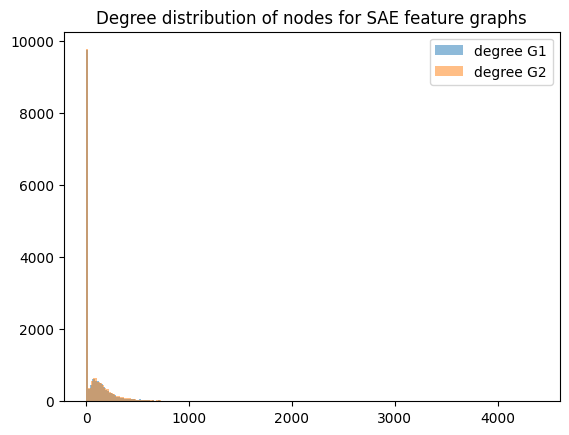

In [159]:
deg1 = graph_code.get_degree(G1)
deg2 = graph_code.get_degree(G2)
plt.hist(deg1, bins=200, alpha=.5, label='degree G1')
plt.hist(deg2, bins=200, alpha=.5, label='degree G2')
plt.title('Degree distribution of nodes for SAE feature graphs')
plt.legend()
plt.show()

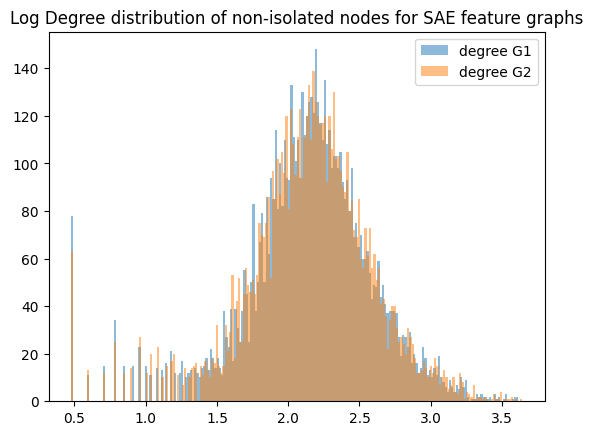

In [167]:
deg1 = graph_code.get_degree(G1)
deg2 = graph_code.get_degree(G2)
plt.hist(deg1[np.where(deg1 > 0)].log10(), bins=200, alpha=.5, label='degree G1')
plt.hist(deg2[np.where(deg2 > 0)].log10(), bins=200, alpha=.5, label='degree G2')
plt.title('Log Degree distribution of non-isolated nodes for SAE feature graphs')
plt.legend()
plt.show()

In [162]:
strength_G1, avg_w_sum_G1 = graph_code.average_sum_of_weights(G1)
strength_G2, avg_w_sum_G2 = graph_code.average_sum_of_weights(G2)
G1_s = np.array(list(map(lambda x: float(x), strength_G1.values())))
G2_s = np.array(list(map(lambda x: float(x), strength_G1.values())))

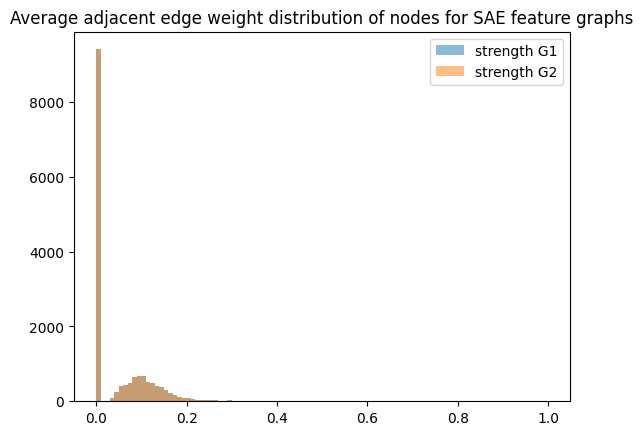

In [130]:
plt.hist(G1_s, bins=100, alpha=.5, label='strength G1')
plt.hist(G2_s, bins=100, alpha=.5, label='strength G2')
plt.title('Average adjacent edge weight distribution of nodes for SAE feature graphs')
plt.legend()
plt.show()

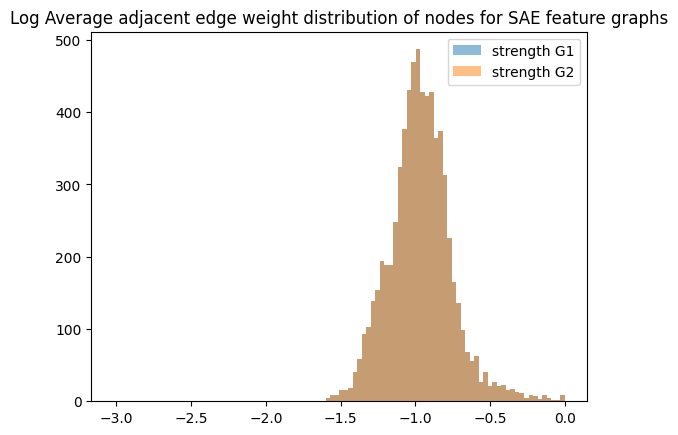

In [164]:
plt.hist(np.log10(G1_s[np.where(G1_s > 0)]), bins=100, alpha=.5, label='strength G1')
plt.hist(np.log10(G2_s[np.where(G2_s > 0)]), bins=100, alpha=.5, label='strength G2')
plt.title('Log Average adjacent edge weight distribution of nodes for SAE feature graphs')
plt.legend()
plt.show()

In [141]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

def compute_divergences(graph1, graph2):
    # Calculate the degree distributions
    degrees_G1 = [d for n, d in graph1.degree()]
    degrees_G2 = [d for n, d in graph2.degree()]
    
    # Get the maximum degree in both graphs to align their distributions
    max_degree = max(max(degrees_G1), max(degrees_G2))
    
    # Compute histograms of degrees to create the distributions
    hist_G1, _ = np.histogram(degrees_G1, bins=np.arange(max_degree + 2), density=True)
    hist_G2, _ = np.histogram(degrees_G2, bins=np.arange(max_degree + 2), density=True)
    
    # Avoid zeros to prevent division by zero in KL divergence
    epsilon = 1e-10
    hist_G1 = np.where(hist_G1 == 0., epsilon, hist_G1)
    hist_G2 = np.where(hist_G2 == 0., epsilon, hist_G2)
    
    # Normalize histograms to ensure they sum to 1
    hist_G1 /= np.sum(hist_G1)
    hist_G2 /= np.sum(hist_G2)
    
    # Compute the Jensen-Shannon divergence
    js_divergence = jensenshannon(hist_G1, hist_G2)
    
    # Compute the Kullback-Leibler divergence (both directions)
    kl_divergence_G1_G2 = entropy(hist_G1, hist_G2)  # KL(G1 || G2)
    kl_divergence_G2_G1 = entropy(hist_G2, hist_G1)  # KL(G2 || G1)
    
    return js_divergence, kl_divergence_G1_G2, kl_divergence_G2_G1

# Compute divergences between their degree distributions
js_divergence, kl_divergence_G1_G2, kl_divergence_G2_G1 = compute_divergences(G1, G2)

print(f"Jensen-Shannon Divergence between degree distributions: {js_divergence}")
print(f"Kullback-Leibler Divergence KL(G1 || G2): {kl_divergence_G1_G2}")
print(f"Kullback-Leibler Divergence KL(G2 || G1): {kl_divergence_G2_G1}")

Jensen-Shannon Divergence between degree distributions: 0.15084110326217234
Kullback-Leibler Divergence KL(G1 || G2): 0.3335302248032783
Kullback-Leibler Divergence KL(G2 || G1): 0.3198694042946108


In [143]:
G3 = nx.gnm_random_graph(len(G1.nodes), len(G1.edges()))
js_divergence, kl_divergence_G1_G3, kl_divergence_G3_G1 = compute_divergences(G1, G3)

print(f"Jensen-Shannon Divergence between degree distributions: {js_divergence}")
print(f"Kullback-Leibler Divergence KL(G1 || G3): {kl_divergence_G1_G3}")
print(f"Kullback-Leibler Divergence KL(G3 || G1): {kl_divergence_G3_G1}")

Jensen-Shannon Divergence between degree distributions: 0.7378191812911915
Kullback-Leibler Divergence KL(G1 || G3): 17.55032609094022
Kullback-Leibler Divergence KL(G3 || G1): 2.660229959018823


### Identify similar nodes (i.e. features) across SAE graphs

In [87]:
from sklearn.preprocessing import MinMaxScaler

def compute_nodes_features(G):
    features = {}
    degree = G.degree()
    strength_G, _ = graph_code.average_sum_of_weights(G)
    clustering_coeff = nx.clustering(G)
    #betweenness = nx.betweenness_centrality(G, normalized=True)
    #closeness = nx.closeness_centrality
    for node in G.nodes():
        features[node] = {}
        features[node]['degree'] = degree[node]
        features[node]['strength'] = float(strength_G[node])
        features[node]['clustering'] = clustering_coeff[node]
    return features

def compute_feature_vector(features):
    return np.array([
        features['degree'],
        features['strength'],
        features['clustering']
    ])

def compute_features(G, features_filepath, idx):
    if features_filepath is None:
        features = compute_nodes_features(G)
        with open(f'features{idx}.pkl', 'wb') as f:
            pickle.dump(features, f)
    else:
        with open(f'features{idx}.pkl', 'rb') as f:
            features = pickle.load(f)
    return features

def find_similar_nodes(G1, x, G2, top_k=5, features1_filepath=None, features2_filepath=None):
    # Get features of all nodes in G1
    features1 = compute_features(G1, features1_filepath, idx=1)
    # Get features of all nodes in G2
    features2 = compute_features(G2, features2_filepath, idx=2)
    x_vector = compute_feature_vector(features1[x]).reshape(1, -1)
    
    # Collect feature vectors for nodes in G2
    nodes = []
    feature_vectors = []
    for node in G2.nodes():
        node_features = features2[node]
        node_vector = compute_feature_vector(node_features)
        nodes.append(node)
        feature_vectors.append(node_vector)
    
    feature_vectors = np.array(feature_vectors)
    
    # Normalize feature vectors
    scaler = MinMaxScaler()
    feature_vectors_scaled = scaler.fit_transform(feature_vectors)
    x_vector_scaled = scaler.transform(x_vector)
    
    # Compute distances
    distances = np.linalg.norm(feature_vectors_scaled - x_vector_scaled, axis=1)
    
    # Pair nodes with distances
    node_distances = list(zip(nodes, distances))
    
    # Sort nodes by similarity (lower distance)
    node_distances.sort(key=lambda x: x[1])
    
    # Return top_k most similar nodes
    return node_distances[:top_k]

In [110]:
similar_nodes = find_similar_nodes(G1, 10391, G2, top_k=10, features1_filepath='features1.pkl',
                                   features2_filepath='features2.pkl')
print("Top similar nodes in G2 to node x in G1:")
for node, distance in similar_nodes:
    print(f"Node {node} with similarity score {distance}")

Top similar nodes in G2 to node x in G1:
Node 694 with similarity score 0.004384871800511734
Node 6940 with similarity score 0.007996313508509042
Node 7099 with similarity score 0.010386564843240327
Node 1605 with similarity score 0.012894727148089763
Node 12301 with similarity score 0.01535848236125028
Node 7747 with similarity score 0.015824836468896687
Node 645 with similarity score 0.01647928977076824
Node 3119 with similarity score 0.019375245957506455
Node 6702 with similarity score 0.019607600966103488
Node 9032 with similarity score 0.019675522818803852


In [99]:
features_utils.get_logit_effect(encoder=encoder_2, model=model, feature_id=6741)

In [126]:
features_utils.interpret_feature(model, encoder=encoder_2, all_tokens=all_tokens, 
                                 feature_id=6741, start_index=0, end_index=128)

hidden_acts.shape torch.Size([16384, 16384])


In [107]:
features_utils.interpret_feature(model, encoder=encoder_1, all_tokens=all_tokens, 
                                 feature_id=16124, start_index=256, end_index=256*2)

hidden_acts.shape torch.Size([32768, 16384])


### Finding communities in the largest component

TODO: generate lower-level communities and analyse results

In [ ]:
subgr = G1.subgraph(nx.node_connected_component(G1, 7))
communities_generator = nx.community.asyn_lpa_communities(subgr, weight='weight')
next_level_communities = []
for comm in communities_generator:
    next_level_communities.extend(list(nx.community.asyn_lpa_communities(G1.subgraph(comm),
                                                                                    weight='weight')))
next_level_communities

### What is the relation between feature degrees and feature frequencies?

In [132]:
# Calculate the Pearson correlation coefficient
correlation_1 = torch.corrcoef(torch.stack((graph_code.get_degree(G1), freqs_1)))[0, 1]
print(f"Correlation between degree and frequency: {correlation_1.item()}")
correlation_2 = torch.corrcoef(torch.stack((graph_code.get_degree(G2), freqs_2)))[0, 1]
print(f"Correlation between degree and frequency: {correlation_2.item()}")

Correlation between degree and frequency: 0.5137686729431152
Correlation between degree and frequency: 0.5235421657562256


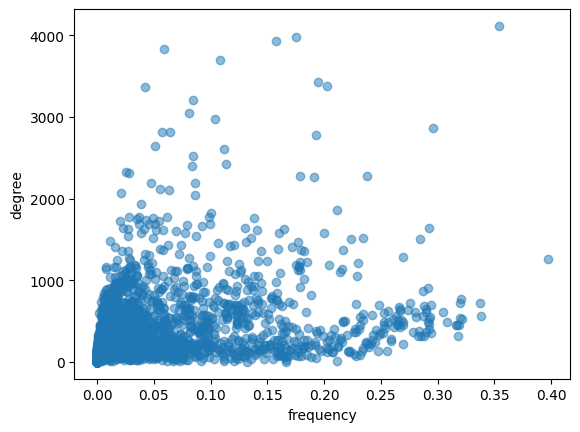

In [165]:
graph_code.plot_degree_vs_freq(G1, freqs_1)

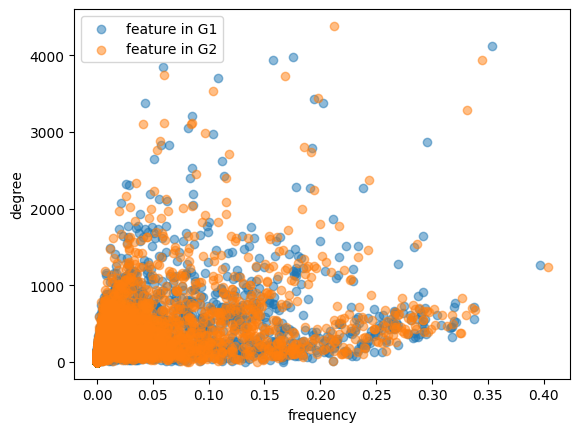

In [166]:
graph_code.plot_degrees_vs_freqs(G1, G2, freqs_1, freqs_2)

### Visualising the largest component

In [135]:
graph_code.plot_connected_component(G1, node=7)

In [369]:
community = list(next_level_communities[1])
graph_code.plot_connected_component(G1.subgraph(community), node=community[0])

### Education related features

In [416]:
G1.edges([16124], data=True)

EdgeDataView([(16124, 215, {'weight': tensor(0.0324)}), (16124, 708, {'weight': tensor(0.1515)}), (16124, 724, {'weight': tensor(0.0873)}), (16124, 1337, {'weight': tensor(0.0876)}), (16124, 1398, {'weight': tensor(0.0557)}), (16124, 2021, {'weight': tensor(0.0175)}), (16124, 2032, {'weight': tensor(0.1781)}), (16124, 2246, {'weight': tensor(0.0250)}), (16124, 2264, {'weight': tensor(0.0311)}), (16124, 2505, {'weight': tensor(0.3547)}), (16124, 3014, {'weight': tensor(0.0436)}), (16124, 3186, {'weight': tensor(0.3766)}), (16124, 3234, {'weight': tensor(0.0887)}), (16124, 3362, {'weight': tensor(0.0367)}), (16124, 4615, {'weight': tensor(0.1153)}), (16124, 4685, {'weight': tensor(0.0305)}), (16124, 4864, {'weight': tensor(0.1506)}), (16124, 5590, {'weight': tensor(0.0413)}), (16124, 5841, {'weight': tensor(0.0333)}), (16124, 7120, {'weight': tensor(0.3306)}), (16124, 7147, {'weight': tensor(0.1058)}), (16124, 7505, {'weight': tensor(0.0482)}), (16124, 7660, {'weight': tensor(0.0139)}), 

In [417]:
features_utils.get_logit_effect(encoder=encoder_1, model=model, feature_id=16124)

In [418]:
features_utils.get_logit_effect(encoder=encoder_1, model=model, feature_id=2505)

### Investigating paths

In [ ]:
G = G1

In [387]:
print(f'Path between pronoun feature and male gender feature: {nx.shortest_path(G, source=7, target=12711, weight=None)}')
print(f'Path between pronoun feature and female gender feature: {nx.shortest_path(G, source=7, target=10391, weight=None)}')
print('=================')
print(f'Weighted Path between pronoun feature and male gender feature: {nx.shortest_path(G, source=7, target=12711, weight=custom_weight)}')
print(f'Weighted Path between pronoun feature and female gender feature: {nx.shortest_path(G, source=7, target=10391, weight=custom_weight)}')

Path between pronoun feature and male gender feature: [7, 13651, 1061, 12711]
Path between pronoun feature and female gender feature: [7, 882, 10391]
Weighted Path between pronoun feature and male gender feature: [7, 14506, 14163, 12711]
Weighted Path between pronoun feature and female gender feature: [7, 13492, 10391]


In [408]:
print(f'Path between bio feature and male gender feature: {nx.shortest_path(G, source=5156, target=12711, weight=None)}')
print(f'Path between bio feature and female gender feature: {nx.shortest_path(G, source=5156, target=10391, weight=None)}')
print('=================')
print(f'Weighted Path between bio feature and male gender feature: {nx.shortest_path(G, source=5156, target=12711, weight=custom_weight)}')
print(f'Weighted Path between bio feature and female gender feature: {nx.shortest_path(G, source=5156, target=10391, weight=custom_weight)}')

Path between bio feature and male gender feature: [5156, 1061, 12711]
Path between bio feature and female gender feature: [5156, 665, 10391]
Weighted Path between bio feature and male gender feature: [5156, 9484, 4830, 12711]
Weighted Path between bio feature and female gender feature: [5156, 6463, 10391]
